# Imports

Runtime Instructions: Latest version of Google Collab with all files from kaggle added to working directory

In [ ]:
!pip3 install u8darts pytorch-lightning

In [91]:
import os
import sys

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.style.use('bmh')

from darts import TimeSeries # We are using Darts for this solution but other librarires fine too.
from darts.utils.statistics import plot_acf, plot_pacf
from darts.models import ExponentialSmoothing
from darts.metrics.metrics import mase, mape

# Q1 a
Solution adapted from N. Bhavya Sree, M.Anusri, Meesala Sreeja

In [ ]:
df_parking_lot = pd.read_csv('parkingLot (1).csv')

In [93]:
df_parking_lot.head()

,vehicle_no,timestamp,camera_id
0,MHUN7063,2024-09-12 05:00:00,1
1,MHYN4677,2024-09-12 05:00:00,1
2,MHEL6595,2024-09-12 05:00:00,1
3,MHNQ2590,2024-09-12 05:00:00,1
4,MHHA0518,2024-09-12 05:00:00,1


In [106]:
# Load the dataset
data = pd.read_csv('parkingLot (1).csv')

In [108]:
# Convert timestamp to datetime and set correct data types
data['timestamp'] = pd.to_datetime(data['timestamp'])
data['camera_id'] = data['camera_id'].astype(str).str.zfill(3)

# Filter data within operational hours (5 AM to 12 AM)
data = data[(data['timestamp'].dt.hour >= 5) & (data['timestamp'].dt.hour < 24)]

# Separate entry and exit data
entry_data = data[data['camera_id'] == '001'].copy()  # Create a copy to avoid SettingWithCopyWarning
exit_data = data[data['camera_id'] == '002'].copy()   # Create a copy to avoid SettingWithCopyWarning

# Handle missing values by forward and backward filling
entry_data['vehicle_no'] = entry_data['vehicle_no'].ffill().bfill()
exit_data['vehicle_no'] = exit_data['vehicle_no'].ffill().bfill()

# Calculate daily entry vehicle counts for Part A
entry_data.set_index('timestamp', inplace=True)
daily_counts = entry_data.resample('D').size().reset_index(name='vehicle_count')

In [95]:
daily_counts

,timestamp,vehicle_count
0,2024-09-12,886
1,2024-09-13,809
2,2024-09-14,925
3,2024-09-15,1073
4,2024-09-16,843
...,...,...
58,2024-11-09,906
59,2024-11-10,944
60,2024-11-11,828
61,2024-11-12,806


In [96]:
# Create Time Series in darts
vehicle_count_ts = TimeSeries.from_dataframe(daily_counts, 'timestamp', 'vehicle_count')
# Split into train test
train_ts, test_ts = vehicle_count_ts[:-7], vehicle_count_ts[-7:]

Text(0, 0.5, 'Daily Vehicle Count')

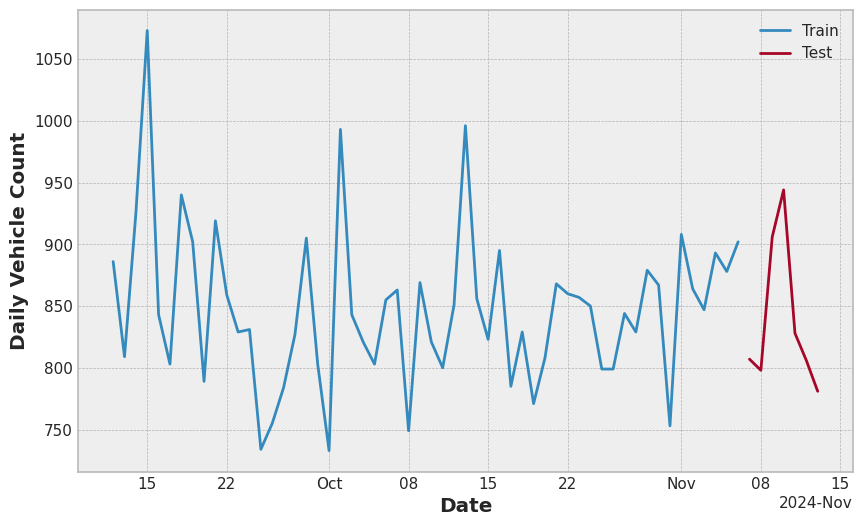

In [97]:
fig, ax = plt.subplots(figsize=(10, 6))
train_ts.plot(ax=ax, label='Train')
test_ts.plot(ax=ax, label='Test')
ax.set_xlabel('Date')
ax.set_ylabel('Daily Vehicle Count')

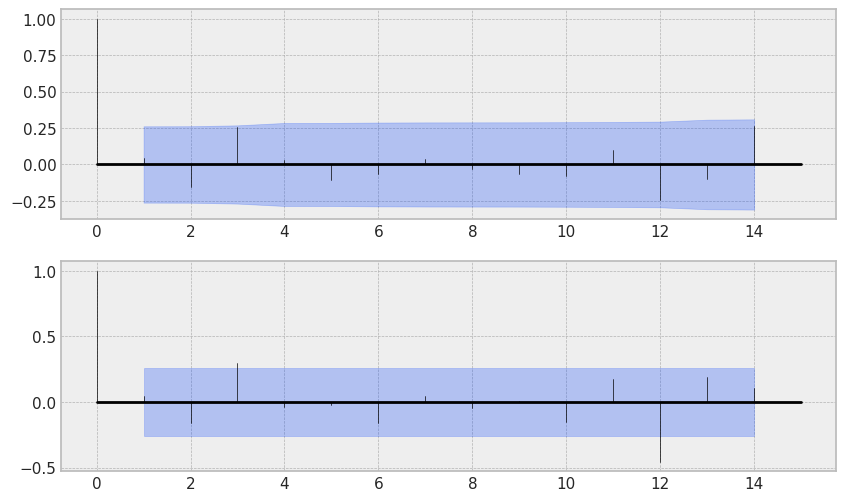

In [98]:
# Plot ACF Pacf for train
fig, ax = plt.subplots(nrows=2,figsize=(10, 6))
plot_acf(train_ts,max_lag=14, axis=ax[0])
plot_pacf(train_ts,max_lag=14, axis=ax[1])

Analysis: The ACF and PACF plot did not show any expected seasonality(spikes at lag 7), but this in itself not enough to conclude that there is no seasonilty in the data as there , to confirm we must also check visually (say by subplots for each season) or by decomposition methods like STL.

In [99]:
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

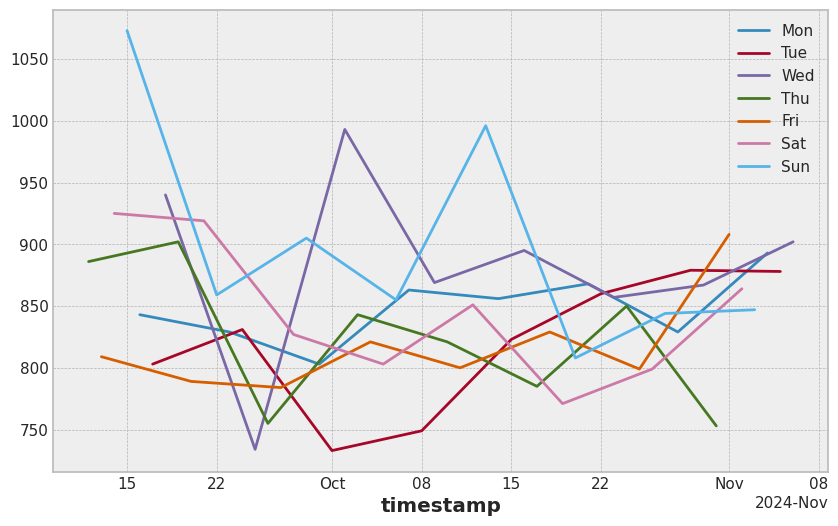

In [100]:
# visual inspection to see if weekly seasonality exists
# Split into seven series, one for each day of the week
fig, ax = plt.subplots(figsize=(10, 6))
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for day, day_label in enumerate(days):
  index_ = train_ts.time_index[train_ts.time_index.day_of_week == day]
  train_ts[index_].plot(ax=ax, label=day_label)

<Axes: xlabel='timestamp'>

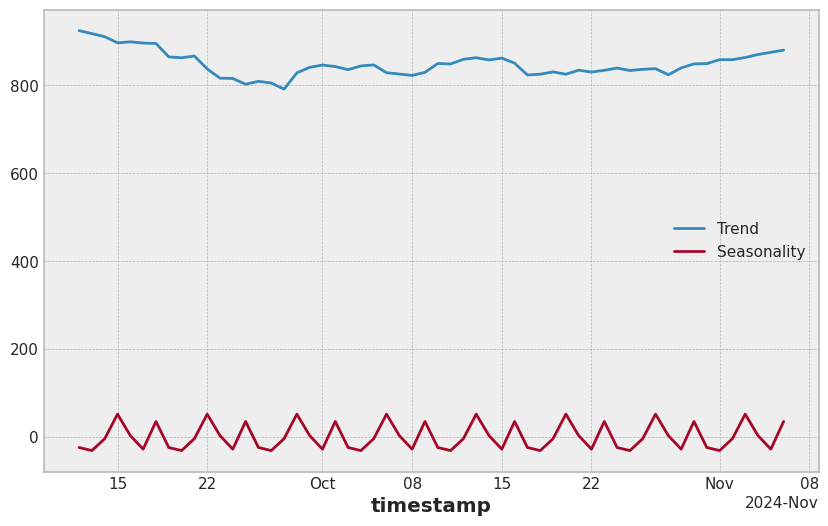

In [101]:
# there seems to be weekly pattern lets try seasonal decomposition
# Can also do this using moving averages if function not present in your choice of library
# check https://www.statsmodels.org/devel/generated/statsmodels.tsa.seasonal.seasonal_decompose.html
from darts.utils.utils import ModelMode, SeasonalityMode
from darts.utils.statistics import extract_trend_and_seasonality

trend, seasonality = extract_trend_and_seasonality(train_ts, seasonal_periods=7, model=ModelMode.ADDITIVE)
fig, ax = plt.subplots(figsize=(10, 6))
trend.plot(ax=ax, label='Trend')
seasonality.plot(ax=ax, label='Seasonality')

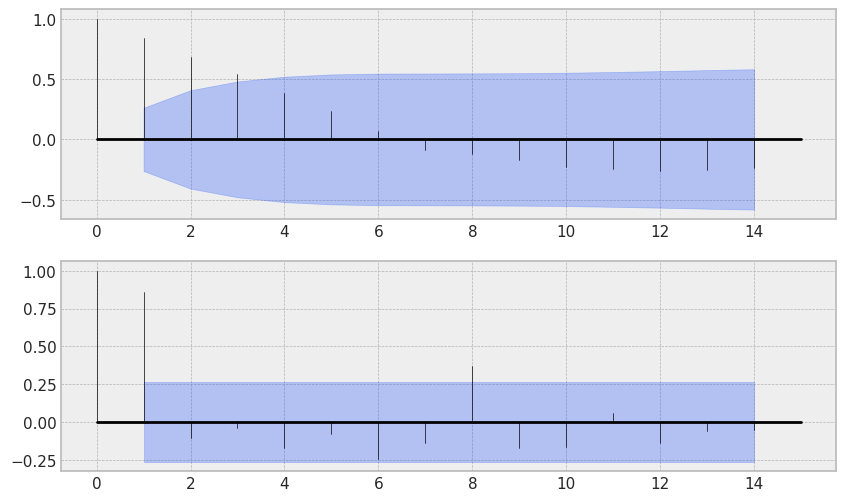

In [102]:
fig, ax = plt.subplots(nrows=2,figsize=(10, 6))
plot_acf(trend, max_lag=14, axis=ax[0])
plot_pacf(trend, max_lag=14, axis=ax[1])

The ACF Plot above for the trend part is typical for ETS process. We see the correlation decreases with each lag and eventually going to 0.

<Axes: xlabel='timestamp'>

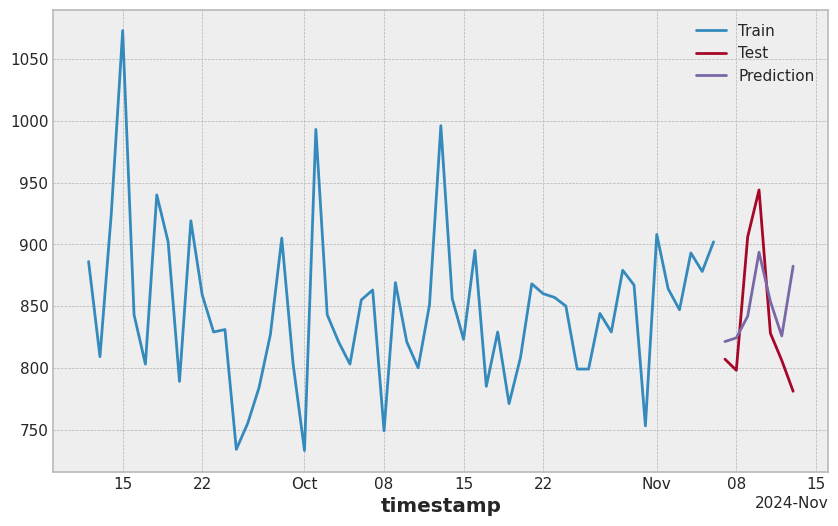

In [103]:
# fitting ETS with seasonal period 7
model = ExponentialSmoothing(seasonal_periods=7)
model.fit(train_ts)
pred = model.predict(7)
fig, ax = plt.subplots(figsize=(10, 6))
train_ts.plot(ax=ax, label='Train')
test_ts.plot(ax=ax, label='Test')
pred.plot(ax=ax, label='Prediction')

In [105]:
# calculate mase, mape
print(f'MASE: {mase(test_ts, pred, insample=train_ts)}')
print(f'MAPE: {mape(test_ts, pred)}')

MASE: 0.6360404899784919
MAPE: 5.145229534307441


# **Rubric**
4 - Any Full attempt at the question not copied from any other team

1 - Correctly setting up validation, plots of acf, pacf and  mape,mase score correctly calculated

1 - Correctly identifying the model to use after analysing the above plots and predicting using it i.e. ETS after decompsition

1 - MAPE score was less than 10 (even if correct model not found)

# Q1 b

In [147]:
# Load the dataset
data = pd.read_csv('parkingLot (1).csv')
# Convert timestamp to datetime and set correct data types
data['timestamp'] = pd.to_datetime(data['timestamp'])
data['camera_id'] = data['camera_id'].astype(str).str.zfill(3)
# Filter data within operational hours (5 AM to 12 AM)
data = data[(data['timestamp'].dt.hour >= 5) & (data['timestamp'].dt.hour < 24)]

In [148]:
# Extract date and create a new column
data['date'] = data['timestamp'].dt.date

In [149]:
len(data)

105439

We will take only those vehicles that have both entry and exit records as otherwise they must have exited during the maintenance period, or the sensor must have corrupted one of the digits, note that unlike part a where we just want to estimate no of vehicles in a day, not doing this might cause significant corruption in estimating the average time spent by a vehicle on a given day.

If you do want to include the flipped digit vehicles, one can try checking the hamming distance between vehicle_id for vehicles having only one record on a particular day and try matching the ones which have low distance. [BONUS 1 marks if someone tried this]

In [150]:
# Group by 'vehicle_id' and 'date' and count the occurrences for each group
grouped_counts = data.groupby(['vehicle_no', 'date']).size().reset_index(name='count')
# Filter only those groups where count is 2
filtered_vehicles = grouped_counts[grouped_counts['count'] == 2]
# Join back with the original data to get full records of filtered vehicles
data = data.merge(filtered_vehicles[['vehicle_no', 'date']], on=['vehicle_no', 'date'])

In [151]:
len(data)

102284

In [152]:
data.head()

,vehicle_no,timestamp,camera_id,date
0,MHUN7063,2024-09-12 05:00:00,001,2024-09-12
1,MHYN4677,2024-09-12 05:00:00,001,2024-09-12
2,MHEL6595,2024-09-12 05:00:00,001,2024-09-12
3,MHNQ2590,2024-09-12 05:00:00,001,2024-09-12
4,MHGS9163,2024-09-12 05:00:00,001,2024-09-12


In [153]:
# rest of data engineering similar to part a
# Calculate time spent by each vehicle
time_spent_by_vehicle = data.groupby(['vehicle_no','date'])['timestamp'].agg(['min', 'max']).reset_index()
time_spent_by_vehicle['time_spent'] = (time_spent_by_vehicle['max'] - time_spent_by_vehicle['min']).dt.total_seconds() / 60

In [154]:
time_spent_by_vehicle.head()

,vehicle_no,date,min,max,time_spent
0,MHAA0030,2024-11-12,2024-11-12 11:00:00,2024-11-12 16:40:00,340.0
1,MHAA0121,2024-09-24,2024-09-24 12:40:00,2024-09-24 20:40:00,480.0
2,MHAA0351,2024-10-08,2024-10-08 05:40:00,2024-10-08 12:00:00,380.0
3,MHAA0507,2024-11-09,2024-11-09 13:00:00,2024-11-09 17:20:00,260.0
4,MHAA0529,2024-09-17,2024-09-17 12:40:00,2024-09-17 18:40:00,360.0


In [155]:
# average time spent per day by a vehicle
avg_time_spent = time_spent_by_vehicle.groupby('date')['time_spent'].mean().reset_index(name='avg_time_spent')

In [156]:
avg_time_spent.head()

,date,avg_time_spent
0,2024-09-12,252.584795
1,2024-09-13,388.221649
2,2024-09-14,493.930705
3,2024-09-15,536.936585
4,2024-09-16,504.113300


In [157]:
avg_time_spent['date'] = pd.to_datetime(avg_time_spent['date'])
# Create Time Series in darts
avg_time_spent_ts = TimeSeries.from_dataframe(avg_time_spent, 'date', 'avg_time_spent')
# Split into train test
train_ts, test_ts = avg_time_spent_ts[:-7], avg_time_spent_ts[-7:]

Text(0, 0.5, 'Average Time Spent in Mall (minutes)')

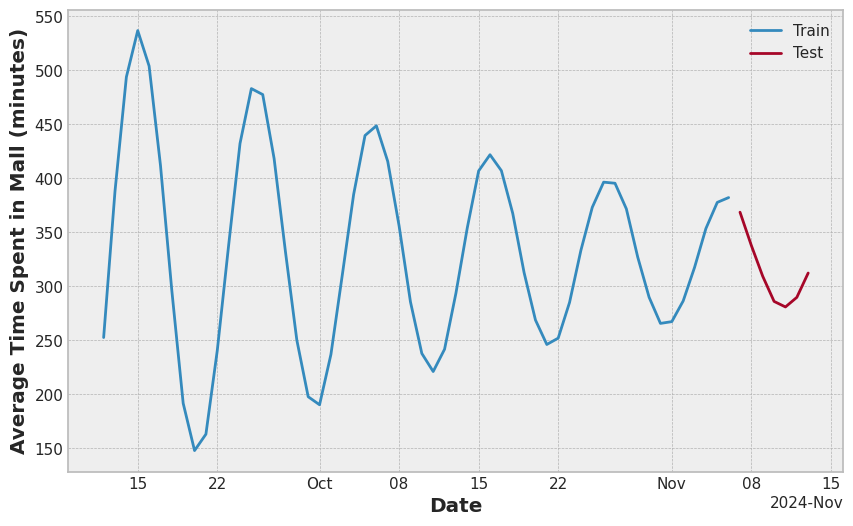

In [158]:
fig, ax = plt.subplots(figsize=(10, 6))
train_ts.plot(ax=ax, label='Train')
test_ts.plot(ax=ax, label='Test')
ax.set_xlabel('Date')
ax.set_ylabel('Average Time Spent in Mall (minutes)')

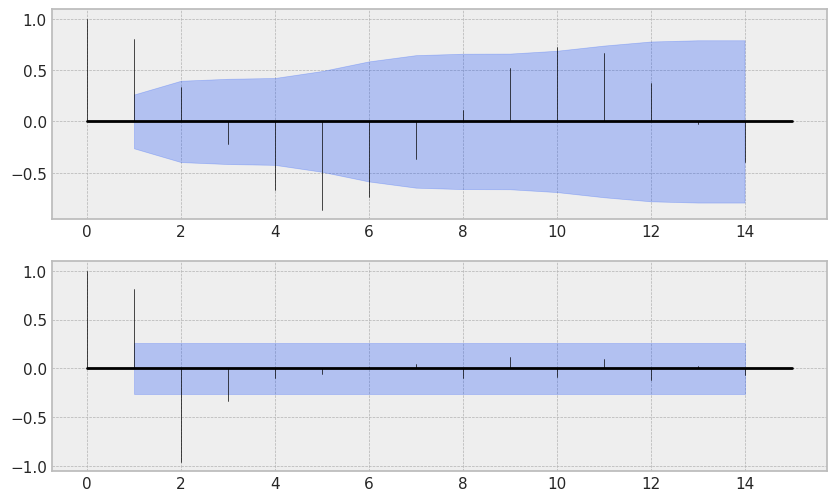

In [159]:
# Plot ACF Pacf for train
fig, ax = plt.subplots(nrows=2,figsize=(10, 6))
plot_acf(train_ts,max_lag=14, axis=ax[0])
plot_pacf(train_ts,max_lag=14, axis=ax[1])

Analysis: From The above plot we can see that the acf plot is alternating while the pacf plot has peaks upto lags 2. Hence it must be an AR(2) process.

<Axes: xlabel='date'>

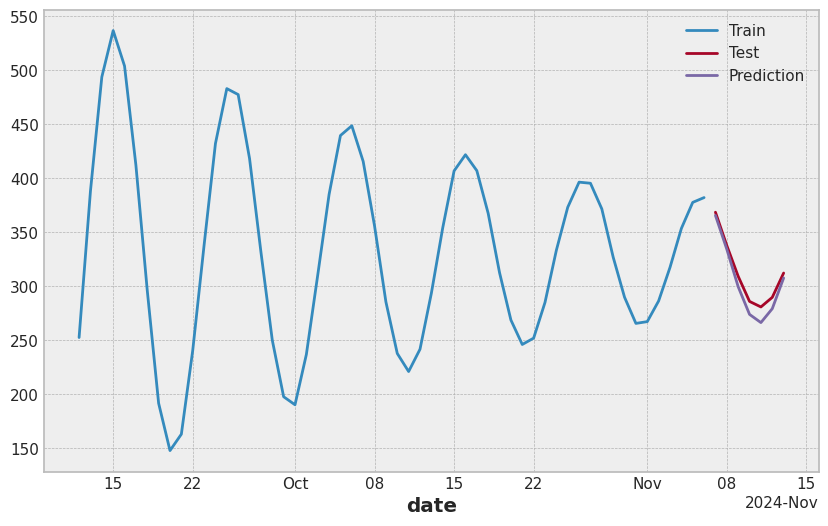

In [161]:
# fit an AR(2) model
from darts.models import ARIMA
model = ARIMA(p=2, d=1, q=0) # not centered so need to take differencing order 1
model.fit(train_ts)
pred = model.predict(7)
fig, ax = plt.subplots(figsize=(10, 6))
train_ts.plot(ax=ax, label='Train')
test_ts.plot(ax=ax, label='Test')
pred.plot(ax=ax, label='Prediction')

In [162]:
# calculate mase, mape
print(f'MASE: {mase(test_ts, pred, insample=train_ts)}')
print(f'MAPE: {mape(test_ts, pred)}')

MASE: 0.17689200760366613
MAPE: 2.772082558505539


# **Rubric**
4 - Any Full attempt at the question not copied from any other team

1 - Plots of Average time spent match to those above

1 - Correctly identifying the model to use after analysing the above plots and predicting using it i.e. ARIMA(2,1,0)

1 - MAPE score was less than 5 (even if any other model used)

[BONUS 1 marks if used hamming distance to match vehicles to calculate time spent by a vehicles whose license plates were missread by the sensor]

# Q1 c

Choose any missing value imputation strategy or any outlier smoothing techniques from the popular ones. And repeat the process.

Another consideration to make is where in the pipeline do we wish to fill the missing values or do outlier smoothing. For example in part a, to get no of vehicles entering in the maintance period by averaging the no of vehichles in the previous and next burst of uploads, or we can do outlier smoothing after aggregating the total number of vehicles are calculated for a particular day.

Marks will be given regardless of what apporach you choose, if two such methods implemented.

# **Rubric**
4 - Any Full attempt at the question not copied from any other team

1 + 1 - Two different missing value strategy correctly implemented


# Q2.1 a, b
winnning submission: N. Bhavya Sree, M.Anusri, Meesala Sreeja

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=3733.517, Time=1.76 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3745.309, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3738.774, Time=0.70 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3732.609, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=3744.212, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=3734.083, Time=0.11 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=3734.286, Time=1.27 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=3734.394, Time=1.87 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=3732.849, Time=0.37 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=3736.285, Time=2.66 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=3743.536, Time=0.06 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=3731.961, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=3734.111, Time=0.07 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=3733.410, Time=0.44 sec
 ARIMA(1,1,1)(0,0,2

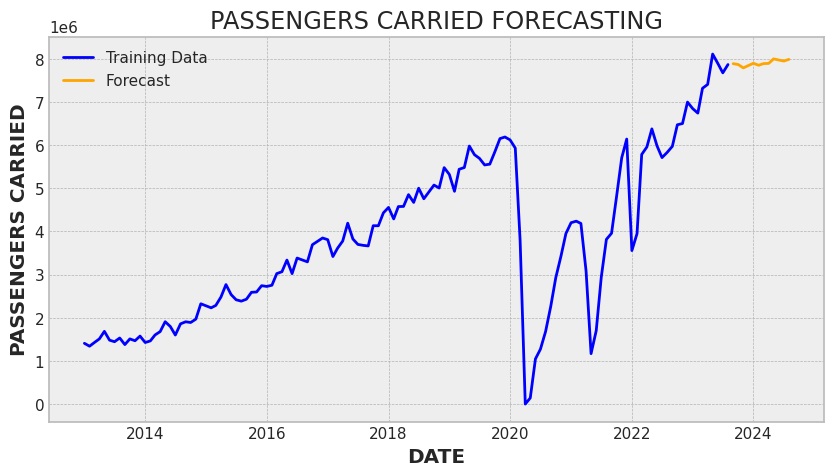

In [163]:
# importing moduels
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

data = pd.read_csv("AirtrafficA4.csv")
data.columns = data.columns.str.strip()
data['MONTH'] = data['MONTH'].str.strip()
# print(data['MONTH'])

# columns in dataset
Columns = ["TOTAL DEPARTURES", "HOURS FLOWN", "KILOMETRE FLOWN",
                "PASSENGERS CARRIED", "AVAILABLE SEAT KILOMETRE (IN THOUSAND)",
                "FREIGHT CARRIED (IN TONNE)", "MAIL CARRIED (IN TONNE)"]

for col in Columns:
    data[col] = pd.to_numeric(data[col].replace({",": ""}, regex=True), errors='coerce')
# replace missing values with 0
data.fillna(0, inplace=True)

# making month mapping
MonthMapping = {
    'JAN': 'Jan', 'FEB': 'Feb', 'MAR': 'Mar', 'APR': 'Apr', 'MAY': 'May',
    'JUN': 'Jun', 'JUL': 'Jul', 'AUG': 'Aug', 'SEP': 'Sep',
    'OCT': 'Oct', 'NOV': 'Nov', 'DEC': 'Dec', 'JUNE': 'Jun', 'JULY': 'Jul'
}
data['MONTH'] = data['MONTH'].str[:3].str.upper().map(MonthMapping)

# Converting 'YEAR' and 'MONTH' to a single datetime column
data['DATE'] = pd.to_datetime(data['YEAR'].astype(str) + "-" + data['MONTH'], format="%Y-%b")
data.set_index('DATE', inplace=True)

# Convert the index to PeriodIndex
data.index = data.index.to_period("M")
data = data.sort_index()
# print(data.index)

# Selecting the 'PASSENGERS CARRIED' column
npassengers = data['PASSENGERS CARRIED']

# training data
ntraining = npassengers.loc[:'2023-08']

model = auto_arima(ntraining,seasonal=True, m=12, stepwise=True, trace=True, suppress_warnings=True,max_p=4,max_d=4,max_q=3,max_P=4,max_D=2,max_Q=4)
# print(model.summary())

sarima_model = SARIMAX(ntraining,order=model.order, seasonal_order=model.seasonal_order)
sarima_result = sarima_model.fit()

# Forecast for the next 12 months
nforecasted = 12
forecast = sarima_result.get_forecast(steps=nforecasted)
ForecastedValues = forecast.predicted_mean
# print(ForecastedValues)

ForecastDF = pd.DataFrame({
    'YEAR_MONTH': ForecastedValues.index.strftime('%Y %b').str.upper(),
    'PASSENGERS CARRIED': ForecastedValues.values.astype(int)
})
ForecastDF['YEAR_MONTH'] = '"' + ForecastDF['YEAR_MONTH'] + '"'

# Writing the forecast to a CSV file
with open('passengers_forecast.csv', 'w', newline='') as file:
    file.write('YEAR_MONTH,PASSENGERS CARRIED\n')
    for index, row in ForecastDF.iterrows():
        file.write(f"{row['YEAR_MONTH']},{row['PASSENGERS CARRIED']}\n")

fIndex = ForecastedValues.index
# indeces for plotting
fIndex = ForecastedValues.index.to_timestamp()
TrainingIndex = ntraining.index.to_timestamp()

# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(TrainingIndex, ntraining, label='Training Data', color='blue')
plt.plot(fIndex, ForecastedValues, label='Forecast', color='orange')
plt.title('PASSENGERS CARRIED FORECASTING')
plt.xlabel('DATE')
plt.ylabel('PASSENGERS CARRIED')
plt.legend()
plt.savefig('Q2a.png')
plt.show()

Alternatively: Looking at the test plot, trying simple MA models with good outlier smoothing to filter covid effects should work.

Q2.1 b

“Given the monthly data for airline operations, forecast the [TARGET COLUMN] for the next
period. Each entry is structured as follows: [AIRLINE], [YEAR], [MONTH], [TOTAL DEPAR-
TURES], [HOURS FLOWN], [KILOMETRE FLOWN], [PASSENGERS CARRIED], [AVAILABLE
SEAT KILOMETRE (IN THOUSAND)], [FREIGHT CARRIED (IN TONNE)], [MAIL CARRIED
(IN TONNE)]. Here is the data: {prompt string}. Predict the next [PASSENGERS CARRIED]
from 2023 September to 2024 August.”

{prompt string} is generated by running the code below.

In [ ]:
def create_prompt_string(row):
    return (
        f"[AIRLINE]: {row['AIRLINE']} [YEAR]: {row['YEAR']} [MONTH]: {row['MONTH']} "
        f"[TOTAL DEPARTURES]: {row['TOTAL DEPARTURES']} [HOURS FLOWN]: {row['HOURS FLOWN']} "
        f"[KILOMETRE FLOWN]: {row['KILOMETRE FLOWN']} [PASSENGERS CARRIED]: {row['PASSENGERS CARRIED']} "
        f"[AVAILABLE SEAT KILOMETRE (IN THOUSAND)]: {row['AVAILABLE SEAT KILOMETRE (IN THOUSAND)']} "
        f"[FREIGHT CARRIED (IN TONNE)]: {row['FREIGHT CARRIED (IN TONNE)']} "
        f"[MAIL CARRIED (IN TONNE)]: {row['MAIL CARRIED (IN TONNE)']}"
    )

# Apply this to each row and join as a single prompt for the LLM
df['prompt_string'] = df.apply(create_prompt_string, axis=1)
prompt_string = " ".join(df['prompt_string'].tolist())

# **Rubric**
4 - Any Full attempt at the question not copied from any other team

2 - Beating the Benchmark on part a Kaggle - MAPE < 3.09

1 - MAPE calculated on validation for part b and less than < 3.09

1 - Bonus for top teams: MAPE less than < 2.00

# Q2.1 c

For this part we want to use global info available in a set of related time series to predict passengers carried by an airline.
This can be done by adding related timeseries as regressors, or past covariates into models that support it. https://medium.com/unit8-machine-learning-publication/time-series-forecasting-using-past-and-future-external-data-with-darts-1f0539585993
Or by using models that share some global parameters that can be trained on multiple timeseries(e.g RNN based models)
See below link for example and why we might be interested in doing something like this.
https://medium.com/unit8-machine-learning-publication/training-forecasting-models-on-multiple-time-series-with-darts-dc4be70b1844

In [ ]:
# Function to remove commas and convert to float
def remove_commas(value):
    try:
        return float(value.replace(',', '')) if isinstance(value, str) else value
    except ValueError:
        return None  # Handle any unexpected values with a fallback
# Specify converters for columns that contain commas
converters = {
    "TOTAL DEPARTURES": remove_commas,
    "HOURS FLOWN": remove_commas,
    "KILOMETRE FLOWN": remove_commas,
    "PASSENGERS CARRIED": remove_commas,
    "AVAILABLE SEAT KILOMETRE (IN THOUSAND)": remove_commas,
    " FREIGHT CARRIED (IN TONNE)": remove_commas,
    "MAIL CARRIED (IN TONNE)": remove_commas
}
AirtrafficA4 = pd.read_csv("AirtrafficA4.csv", converters=converters)
# Clean column names by stripping any leading or trailing spaces
AirtrafficA4.columns = AirtrafficA4.columns.str.strip()
AirtrafficA4['date'] = pd.to_datetime(AirtrafficA4['YEAR'].astype(str) + '-' + AirtrafficA4['MONTH'].astype(str) + '-01')
# Create a new column with month-end dates
AirtrafficA4['month_end'] = AirtrafficA4['date'] + pd.offsets.MonthEnd(0)
# Sort the DataFrame by the 'Date' column
AirtrafficA4 = AirtrafficA4.sort_values(by='date')

AirtrafficA4['PASSENGERS CARRIED'].fillna(0, inplace=True)
AirtrafficA4['HOURS FLOWN'].fillna(0, inplace=True)
AirtrafficA4['KILOMETRE FLOWN'].fillna(0, inplace=True)
AirtrafficA4['TOTAL DEPARTURES'].fillna(0, inplace=True)

In [230]:
passengers_ts = TimeSeries.from_dataframe(AirtrafficA4, time_col='date', value_cols='PASSENGERS CARRIED', freq='MS')
kms_flown_ts = TimeSeries.from_dataframe(AirtrafficA4, time_col='date', value_cols='KILOMETRE FLOWN', freq='MS')
hrs_flown_ts = TimeSeries.from_dataframe(AirtrafficA4, time_col='date', value_cols='HOURS FLOWN', freq='MS')
ttl_departures = TimeSeries.from_dataframe(AirtrafficA4, time_col='date', value_cols='TOTAL DEPARTURES', freq='MS')

In [231]:
# we will smooth outliers for handling covid
from darts.models import MovingAverageFilter
model = MovingAverageFilter(window= 8)
passengers_ts_ = model.filter(passengers_ts)
kms_flown_ts_ = model.filter(kms_flown_ts)
hrs_flown_ts_ = model.filter(hrs_flown_ts)
ttl_departures_ = model.filter(ttl_departures)

In [222]:
# we will be using Regression to forecast adding these other series as past_covariates parameter
from darts.models import Prophet, LinearRegressionModel
# we are using 10 lags and 2 lags of past covariates as regressors to capture global info
model = LinearRegressionModel(lags=10, lags_past_covariates=2,output_chunk_length=12)
model.fit(passengers_ts_, past_covariates= kms_flown_ts_.stack(hrs_flown_ts_).stack(ttl_departures_))
forecast = model.predict(n=12, past_covariates=kms_flown_ts_.stack(hrs_flown_ts_).stack(ttl_departures_))

<Axes: xlabel='date'>

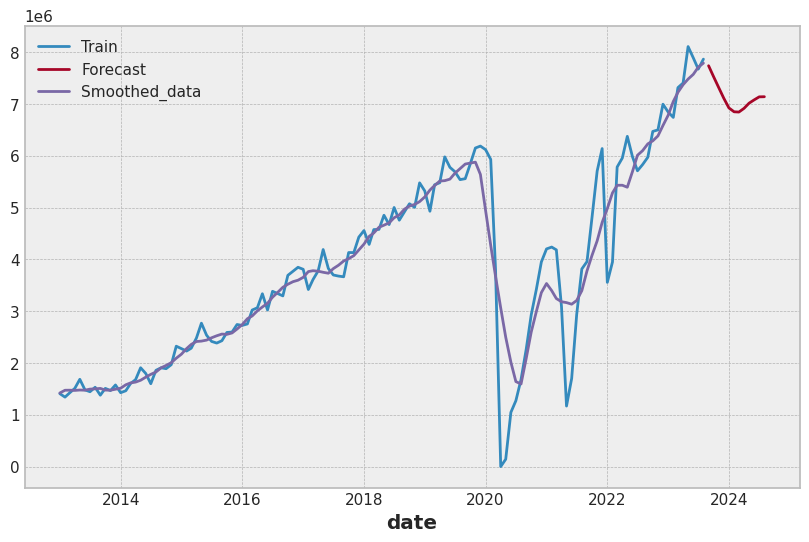

In [223]:
fig, ax = plt.subplots(figsize=(10, 6))
passengers_ts.plot(ax=ax, label='Train')
forecast.plot(ax=ax, label='Forecast')
passengers_ts_.plot(ax=ax, label='Smoothed_data')

Alternate Method:

In [232]:
# Alternatively Using Prophet
# Prophet only supports Future covariates(regressors for which even fututre valuesin forecast horizon are known)
# so we need to estimate them first by forecasting related series using simple methods like Moving average
from darts.models import NaiveMovingAverage
model = NaiveMovingAverage(input_chunk_length=6)

model.fit(kms_flown_ts_)
kms_flown_ts_ = kms_flown_ts_.append(model.predict(12))

model.fit(hrs_flown_ts_)
hrs_flown_ts_ = hrs_flown_ts_.append(model.predict(12))

model.fit(ttl_departures_)
ttl_departures_ = ttl_departures_.append(model.predict(12))


In [234]:
model = Prophet()
model.fit(passengers_ts_, future_covariates= kms_flown_ts_.stack(hrs_flown_ts_).stack(ttl_departures_))
forecast = model.predict(n=12, future_covariates=kms_flown_ts_.stack(hrs_flown_ts_).stack(ttl_departures_))

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp13k4nau0/98x8c776.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp13k4nau0/0coowvjz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88383', 'data', 'file=/tmp/tmp13k4nau0/98x8c776.json', 'init=/tmp/tmp13k4nau0/0coowvjz.json', 'output', 'file=/tmp/tmp13k4nau0/prophet_modelkgviag_q/prophet_model-20241109080538.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:05:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:05:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


<Axes: xlabel='date'>

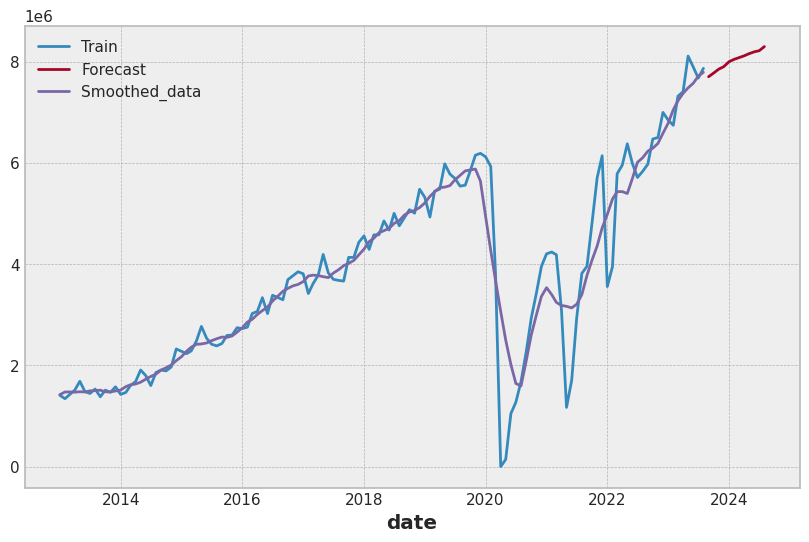

In [235]:
fig, ax = plt.subplots(figsize=(10, 6))
passengers_ts.plot(ax=ax, label='Train')
forecast.plot(ax=ax, label='Forecast')
passengers_ts_.plot(ax=ax, label='Smoothed_data')

# **Rubric**
3 - Any Full attempt at the question not copied from any other team

1 - Used external regressors from other columns or as past-covariates or as future-covariates or other ways to capture info from these other columns to predict passengers carried.


# Q2.2

For this part of the question we are looking for any kind of original thinking valid for our case rather than boilerplate answers about general drawbacks of MAPE.

e.g Answer:

from - Rishi Kalra, Mehul Borad, Chidvilas Reddy:-

"MAPE may not be a good metric to evaluate the demand forecasts because,
MAPE overestimates the error in the case where the actual value is low, we
can clearly see why it is so from the definition of MAPE, i.e MAPE is some-
what like (difference)/(actual value) , so when actual value is low, it overesti-
mates(inflates) the error, and when actual value is high, it underestimates the
error. But since these demand forecasts are used for fleet and human resource
requirements, and human resource is constrained by the peak demand, if we es-
timate peak demand case errors wrongly(since MAPE gives low weightage to peak demand cases), then it is a huge loss for the airline company, so we
should give high weightage to the errors in the case of peak demands compared
to the low demand, but in the case of MAPE quite opposite is happening(low
weightage for peak demand). Hence, MAPE is not a good metric. MAPE can
mislead the company about the prediction’s overall performance, making it ap-
pear worse than it might actually be during peak periods, which are critical for
planning.
We can rather use RMSE (root mean square error) as RMSE gives similar
weightages to peak and low demand cases or even better we can use weighted
root mean square error with more weights to the peak demand cases, so that our
airline company can correctly understand the accuracy of the prediction and go
further for deciding the human/fleet requirements."

Key Idea that we wanted: Since we care about aggregate error of forecast for the next quarter fleet planning, we should simply choose Aggregated forecast error:

$E_{Q} = \sum_{t=T+1}^{T+3} \left( A_t - F_t \right)$

Where A_t is Actual F_t is forecast. Similarly for human resource planning we can just use peak error. The reason we should not just use MAPE in our case as we can easily create examples of two different forecast for a given test data such that the MAPE is better for one of them but the aggregated error is lower for the other. Similar cases can be constructed for peak error easily. Unfortunately this cant be rectified by replacing MAPE with any other error which is mean of a normalised value, e.g: MAPE,MASE, MSSE:Mean Squared Scaled Error,Root Mean Squared Scaled Error. see https://doi.org/10.1145/5666.5673

# **Rubric**
2 - Any original thought process not copied from other teams.

1.5 - Captured the key idea even if the above metric not suggested

0.5 - The above metrics suggested (aggregated error over the next forecasted quarter for fleet planning/ peak error for human resource planning)

# Q2.3
from Jigyasa Chouhan, Gowri K Balakrishnan, Aryan Mahajan

To test if the mean (µ) of the differenced series ∆Y was different pre-COVID
(before December 2019) and post-COVID (after January 2022), a two-sample
t-test would be appropriate. This test compares the means of two independent
samples (pre- and post-COVID) to assess if there is a statistically significant
difference between them.
Since ∆Y is assumed to be weakly stationary and follows a normal distribution
with mean µ and known variance σ, the two-sample t-test is a valid choice for
determining if the means of the two periods are significantly different.

# **Rubric**
4 - The above test suggested